In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR ,ReduceLROnPlateau
import time 

In [2]:
E_modulus = 200  
C1, C2 = 400, 600
noise_level = 0  
def generate_nonlinear_elastic_data(epsilon_values, E, C1, C2, noise_level):
    sigma = E * epsilon_values + C1 * epsilon_values ** 2 + C2 * epsilon_values ** 3
    noise = noise_level * np.random.randn(*epsilon_values.shape)
    return sigma + noise
epsilon_train = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_train = generate_nonlinear_elastic_data(epsilon_train, E_modulus, C1, C2, noise_level).astype(np.float32)
epsilon_train_tensor = torch.tensor(epsilon_train)
sigma_train_tensor = torch.tensor(sigma_train)
std_train_stress = torch.std(sigma_train_tensor).item()
# Normalize the data using min-max normalization
x_data = epsilon_train_tensor.numpy()
y_data = sigma_train_tensor.numpy()
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()
x_data = (x_data - x_min) / (x_max - x_min)
y_data = (y_data - y_min) / (y_max - y_min)
x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)
# Create DataLoader for shuffling
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [3]:
class SoftplusSquared(nn.Module):
    def __init__(self, beta=1):
        super(SoftplusSquared, self).__init__()
        self.beta = nn.Parameter(torch.tensor(float(beta)))  # Make beta a trainable parameter
    def forward(self, x):
        return (1 / (2 * self.beta ** 4)) * (torch.log10(1+torch.exp(self.beta ** 2 * x))) ** 2

class ConstrainedLinear(nn.Module):
    def __init__(self, in_features, out_features, alpha=1):
        super(ConstrainedLinear, self).__init__()
        self.raw_weights = nn.Parameter(torch.empty(out_features, in_features))  
        self.bias = nn.Parameter(torch.zeros(out_features))  
        self.alpha = nn.Parameter(torch.tensor(float(alpha))) 
        # Initialize raw weights with Xavier initialization to balance variance
        nn.init.xavier_uniform_(self.raw_weights)

    def forward(self, x):
        # Constrain weights to be positive using numerically stable softplus
        positive_weights = (1 / (self.alpha ** 2)) * torch.log10(1 + torch.exp(self.alpha ** 2 * self.raw_weights))
        return nn.functional.linear(x, positive_weights, self.bias)

class Passthrough_quadratic(nn.Module):
    def __init__(self, in_features, out_features):
        super(Passthrough_quadratic, self).__init__()
        self.A = nn.Parameter(torch.zeros(out_features, in_features))
    def forward(self, x):
        Ax = nn.functional.linear(x, self.A, None)
        return torch.diag(torch.matmul(Ax, Ax.T)).view(-1, 1)
        
class ICNN_elastic_potential(nn.Module):
    def __init__(self):
        super().__init__()
        # Input, hidden layer, and output sizes
        n_input = 1
        n_hidden1 = 60
        n_hidden2 = 60
        n_hidden3 = 60
        n_output = 1
        
        self.layer1 = nn.Linear(n_input, n_hidden1)
        self.activation1 = SoftplusSquared()
        self.layer2 = ConstrainedLinear(n_hidden1, n_hidden2)
        self.passthrough2 = nn.Linear(n_input, n_hidden2, bias=False)
        self.activation2 = SoftplusSquared()
        self.layer3 = ConstrainedLinear(n_hidden2, n_hidden3)
        self.passthrough3 = nn.Linear(n_input, n_hidden3, bias=False)
        self.activation3 = SoftplusSquared()
        self.layer4 = ConstrainedLinear(n_hidden3, n_output)
        self.passthrough4 = Passthrough_quadratic(n_input, n_input)
        
    def forward_ICNN(self, x):
        # Save original input for passthrough
        x0 = torch.clone(x)
        x1 = self.activation1(self.layer1(x))
        x2 = self.activation2(self.layer2(x1) + self.passthrough2(x0))
        x3 = self.activation3(self.layer3(x2) + self.passthrough3(x0))
        output = self.layer4(x3) + self.passthrough4(x0)
        return output

    def forward(self, x):
        x_zeros = torch.zeros_like(x)
        x_var = torch.zeros_like(x, requires_grad=True)
        forward_ICNN = self.forward_ICNN(x_var)
        forward_ICNN_d = torch.autograd.grad(forward_ICNN, x_var, create_graph=True)[0]
        output = self.forward_ICNN(x) - torch.dot(forward_ICNN_d[0], x[0]).view(1, 1) - self.forward_ICNN(x_zeros)
        return output

In [4]:

model = ICNN_elastic_potential()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1) 
# scheduler = ReduceLROnPlateau(optimizer, 'min')

# inspect the model
def inspect_layers(model, parent_name=""):
    print(f"{'Layer Name':<30} {'Has Bias':<10} {'Trainable':<10} {'Parameter Name':<20}")
    print("-" * 70)
    
    def recurse(module, parent_name=""):
        for name, layer in module.named_children():
            full_name = f"{parent_name}.{name}" if parent_name else name
            if list(layer.parameters()):  # Layer with parameters
                for param_name, param in layer.named_parameters():
                    has_bias = "Yes" if hasattr(layer, "bias") and layer.bias is not None else "No"
                    trainable = "Yes" if param.requires_grad else "No"
                    print(f"{full_name:<30} {has_bias:<10} {trainable:<10} {param_name:<20}")
            else:  # Pass-through layer with no parameters
                print(f"{full_name:<30} {'N/A':<10} {'N/A':<10} {'No Parameters':<20}")
            recurse(layer, full_name)
    
    recurse(model, parent_name)

inspect_layers(model)


Layer Name                     Has Bias   Trainable  Parameter Name      
----------------------------------------------------------------------
layer1                         Yes        Yes        weight              
layer1                         Yes        Yes        bias                
activation1                    No         Yes        beta                
layer2                         Yes        Yes        raw_weights         
layer2                         Yes        Yes        bias                
layer2                         Yes        Yes        alpha               
passthrough2                   No         Yes        weight              
activation2                    No         Yes        beta                
layer3                         Yes        Yes        raw_weights         
layer3                         Yes        Yes        bias                
layer3                         Yes        Yes        alpha               
passthrough3                   No        

Epoch [1/1000], Loss: 0.02369784191250801, LR: 0.01, Time Remaining: 22.78 minutes
Epoch [2/1000], Loss: 0.0022741947323083878, LR: 0.01, Time Remaining: 23.74 minutes
Epoch [3/1000], Loss: 0.005706216208636761, LR: 0.01, Time Remaining: 22.02 minutes
Epoch [4/1000], Loss: 0.002219157526269555, LR: 0.01, Time Remaining: 21.85 minutes
Epoch [5/1000], Loss: 0.0013014816213399172, LR: 0.01, Time Remaining: 21.35 minutes
Epoch [6/1000], Loss: 0.0, LR: 0.01, Time Remaining: 21.39 minutes
Epoch [7/1000], Loss: 0.00010937335173366591, LR: 0.01, Time Remaining: 21.39 minutes
Epoch [8/1000], Loss: 0.00040449167136102915, LR: 0.01, Time Remaining: 21.04 minutes
Epoch [9/1000], Loss: 0.000175392662640661, LR: 0.01, Time Remaining: 20.84 minutes
Epoch [10/1000], Loss: 0.0029597131069749594, LR: 0.01, Time Remaining: 20.74 minutes
Epoch [11/1000], Loss: 0.000795483763795346, LR: 0.01, Time Remaining: 20.57 minutes
Epoch [12/1000], Loss: 0.003274146933108568, LR: 0.01, Time Remaining: 20.59 minutes


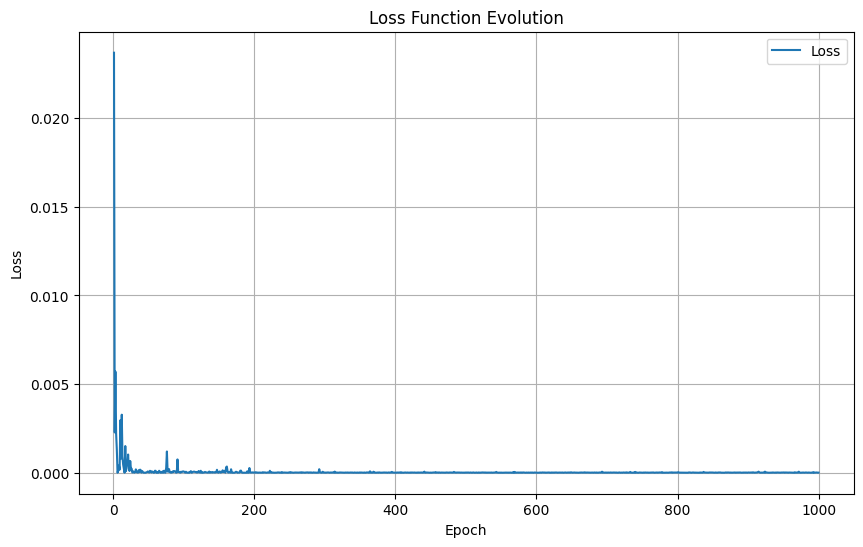

Model saved successfully!


In [5]:
# training 

epochs = 1000
losses = []
start_time = time.time()  

for epoch in range(epochs):
    epoch_start_time = time.time() 
    model.train()
    for batch_x, batch_y in dataloader:
        batch_x.requires_grad_()
        optimizer.zero_grad()
        output = model(batch_x) 
        sigma_p = torch.autograd.grad(output, batch_x, create_graph=True)[0]
        criterion = nn.MSELoss()
        loss = criterion(sigma_p, batch_y)
        loss.backward()
        optimizer.step()
    scheduler.step()

    losses.append(loss.item())
    
    # Calculate elapsed time and estimated time remaining
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    time_remaining = avg_time_per_epoch * (epochs - (epoch + 1)) / 60  # Convert to minutes
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}, Time Remaining: {time_remaining:.2f} minutes')

# Plot the loss evolution
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.grid(True)
plt.show()


# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'losses': losses,
#     'scheduler_state_dict': scheduler.state_dict(),
# }, "trained_model_10K.pth")
# print("Model and loss saved successfully!")

# Save the trained model
# torch.save(model, "trained_model.pth")
torch.save(model, "trained_model_1K.pth")
print("Model saved successfully!")
    
    



C:\Users\A_structure\AppData\Local\Temp\ipykernel_14984\1947633924.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("trained_model.pth")
C:\Users\A_str

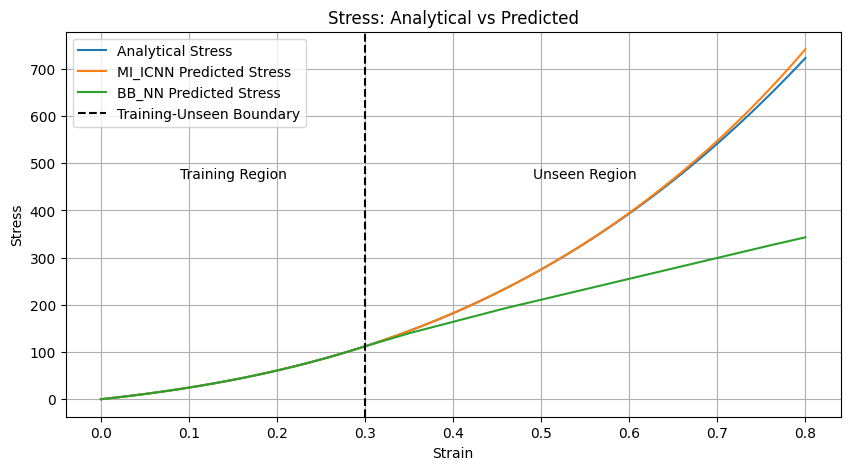

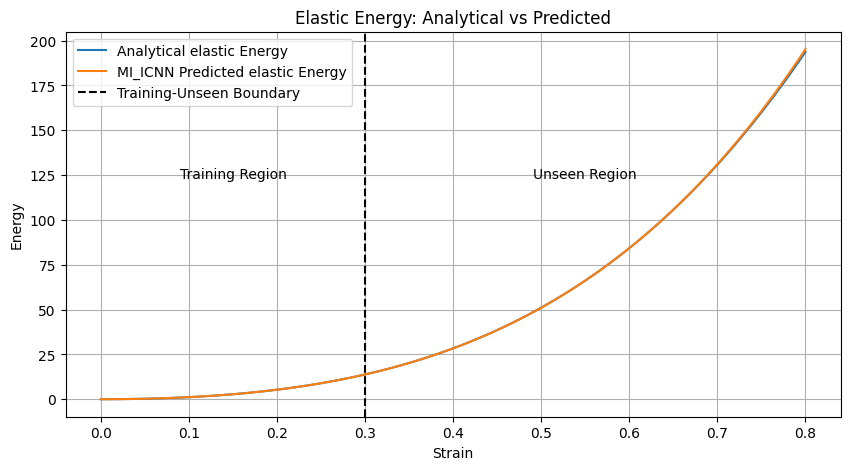

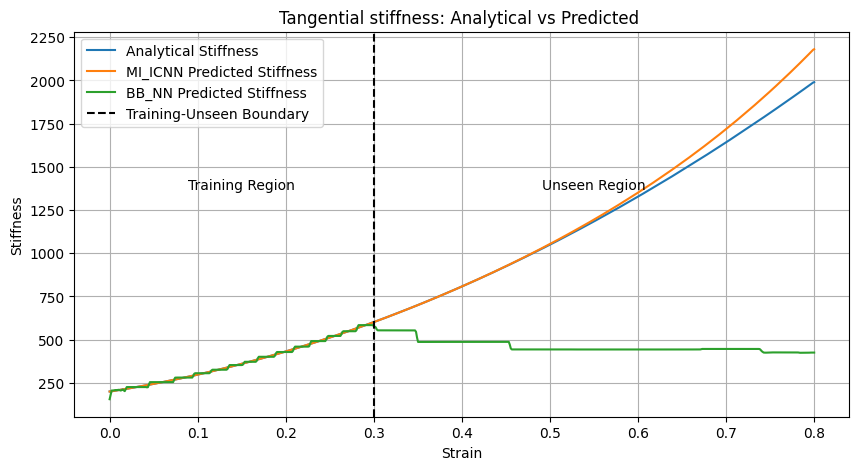

In [6]:
model = torch.load("trained_model.pth")
model.eval()


# model.load_state_dict(model['model_state_dict'])
# optimizer.load_state_dict(model['optimizer_state_dict'])
# losses = model['losses']


def denormalize(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

# Adjust denormalization for energy
def denormalize_energy(energy, x_min, x_max, y_min, y_max):
    x_scale = x_max - x_min
    y_scale = y_max - y_min
    return energy * (x_scale * y_scale)

# Initialize lists to store denormalized results
all_strain = []
all_real_energy = []

all_pred_energy = []
all_real_stress = []
all_pred_stress_ = []

epsilon_validation = np.linspace(0, 0.8, 700).reshape(-1, 1).astype(np.float32)
sigma_validation = generate_nonlinear_elastic_data(
    epsilon_validation, E_modulus, C1, C2, noise_level
).astype(np.float32)


epsilon_validation_tensor = torch.tensor(epsilon_validation)
sigma_validation_tensor = torch.tensor(sigma_validation)
x_data = epsilon_validation_tensor.numpy()
y_data = sigma_validation_tensor.numpy()

x_data = (x_data - x_min) / (x_max - x_min)
y_data = (y_data - y_min) / (y_max - y_min)
x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Iterate through the data loader
for batch_x, batch_y in dataloader:
    batch_x.requires_grad_()
    pred_energy = model(batch_x)
    pred_stress = torch.autograd.grad(pred_energy, batch_x, create_graph=True)[0]
    strain = denormalize(batch_x.detach().numpy(), x_min, x_max)
    real_stress = denormalize(batch_y.detach().numpy(), y_min, y_max)
    # strain = batch_x.detach().cpu().numpy()
    # real_stress = batch_y.detach().cpu().numpy()
    real_energy = 0.5 * E_modulus * strain ** 2 + (C1 / 3) * strain ** 3 + (C2 / 4) * strain ** 4
    pred_energy = denormalize_energy(pred_energy.detach().numpy(), x_min, x_max, y_min, y_max)
    pred_stress = denormalize(pred_stress.detach().numpy(), y_min, y_max)
    # Store results
    all_strain.append(strain)
    all_real_energy.append(real_energy)
    all_pred_energy.append(pred_energy)
    all_real_stress.append(real_stress)
    all_pred_stress_.append(pred_stress)

# Convert lists to arrays
all_strain = np.concatenate(all_strain)
all_real_energy = np.concatenate(all_real_energy)
all_pred_energy = np.concatenate(all_pred_energy)
all_real_stress = np.concatenate(all_real_stress)
all_pred_stress_ = np.concatenate(all_pred_stress_)


# load Black box trained network with same hyperparams

class BlackBoxNN(nn.Module):
    def __init__(self, hidden_dim, num_hidden_layers):
        super(BlackBoxNN, self).__init__()
        self.input_layer = nn.Linear(1, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, epsilon):
        x = torch.relu(self.input_layer(epsilon))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        
        return self.output_layer(x)
model_bb = torch.load("black_box_nn.pth")
model_bb.eval()
pred_sigma_test = model_bb(epsilon_validation_tensor).detach().numpy()

# Plot stress
plt.figure(figsize=(10, 5))
plt.plot(all_strain, all_real_stress, label='Analytical Stress')
plt.plot(all_strain, all_pred_stress_, label='MI_ICNN Predicted Stress')
plt.plot(all_strain, pred_sigma_test, label='BB_NN Predicted Stress')
plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.text(0.15, plt.ylim()[1] * 0.6, 'Training Region', ha='center', fontsize=10)
plt.text(0.55, plt.ylim()[1] * 0.6, 'Unseen Region', ha='center', fontsize=10)
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Stress: Analytical vs Predicted')
plt.legend()
plt.grid()
plt.show()

# Plot energy
plt.figure(figsize=(10, 5))
plt.plot(all_strain, all_real_energy, label='Analytical elastic Energy')
plt.plot(all_strain, all_pred_energy, label='MI_ICNN Predicted elastic Energy')
plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.text(0.15, plt.ylim()[1] * 0.6, 'Training Region', ha='center', fontsize=10)
plt.text(0.55, plt.ylim()[1] * 0.6, 'Unseen Region', ha='center', fontsize=10)
plt.xlabel('Strain')
plt.ylabel('Energy')
plt.title('Elastic Energy: Analytical vs Predicted')
plt.legend()
plt.grid()
plt.show()


# Compute stiffness (derivative of stress with respect to strain)
all_real_stiffness = np.gradient(all_real_stress.flatten(), all_strain.flatten())
all_pred_stiffness = np.gradient(all_pred_stress_.flatten(), all_strain.flatten())
all_bb_stiffness = np.gradient(pred_sigma_test.flatten(), all_strain.flatten())
# Plot stiffness comparison
plt.figure(figsize=(10, 5))
plt.plot(all_strain, all_real_stiffness, label='Analytical Stiffness')
plt.plot(all_strain, all_pred_stiffness, label='MI_ICNN Predicted Stiffness')
plt.plot(all_strain, all_bb_stiffness, label='BB_NN Predicted Stiffness')
plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.text(0.15, plt.ylim()[1] * 0.6, 'Training Region', ha='center', fontsize=10)
plt.text(0.55, plt.ylim()[1] * 0.6, 'Unseen Region', ha='center', fontsize=10)
plt.xlabel('Strain')
plt.ylabel('Stiffness')
plt.title('Tangential stiffness: Analytical vs Predicted ')
plt.legend()
plt.grid()

